In [ ]:
!pip install pandas matplotlib opencv-python numpy tqdm SimpleITK pydicom scikit-learn transformers torch torchvision

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pydicom
import numpy as np
import os
import glob
from tqdm import tqdm
import SimpleITK as sitk
import re
from PIL import Image
import math
import torch
import random
from torchvision import transforms
from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor,Lambda

In [5]:
#Paths
train_csv_path = "/home/tiny_ling/projects/kaggle/rsna-2024-lumbar-degenerative-classication/rsna-2024-lumbar-spine-degenerative-classification/train.csv"
train_label_coordinates_path = "/home/tiny_ling/projects/kaggle/rsna-2024-lumbar-degenerative-classication/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv"
train_series_desc_path = "/home/tiny_ling/projects/kaggle/rsna-2024-lumbar-degenerative-classication/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv"
train_images_path = "/home/tiny_ling/projects/kaggle/rsna-2024-lumbar-degenerative-classication/rsna-2024-lumbar-spine-degenerative-classification/train_images"

In [10]:
# Data preprocessing Functions
def visualize_histogram(image):
    plt.hist(image, bins=256, range=[np.min(image), np.max(image)], color='blue', alpha=0.7)
    


def histogram_match(src, dst):
    src = src * 255.0
    dst = dst * 255.0
    src = src.astype(np.uint8)
    dst = dst.astype(np.uint8)
    res = np.zeros_like(dst)

    cdf_src = np.zeros((3, 256))
    cdf_dst = np.zeros((3, 256))
    cdf_res = np.zeros((3, 256))
    kw = dict(bins=256, range=(0, 256), density=True)
    for ch in range(3):
        his_src, _ = np.histogram(src[:, :, ch], **kw)
        hist_dst, _ = np.histogram(dst[:, :, ch], **kw)
        cdf_src[ch] = np.cumsum(his_src)
        cdf_dst[ch] = np.cumsum(hist_dst)
        index = np.searchsorted(cdf_src[ch], cdf_dst[ch], side='left')
        np.clip(index, 0, 255, out=index)
        res[:, :, ch] = index[dst[:, :, ch]]
        his_res, _ = np.histogram(res[:, :, ch], **kw)
        cdf_res[ch] = np.cumsum(his_res)
    return res / 255.0


def bias_field_correction(image):
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    image = sitk.Cast(image, sitk.sitkFloat32)  # Cast to float32
    corrected_image = corrector.Execute(image)
    return corrected_image    
    
def z_score_normalization(image):
    # Convert the image to an array
    image_array = sitk.GetArrayFromImage(image)
    
    # Calclulate needed starts
    mean = np.mean(image_array)
    std = np.std(image_array)
    
    # Normalize the array and covert it back to an image
    normalized_array = (image_array - mean) / std
    normalized_image = sitk.GetImageFromArray(normalized_array)
    normalized_image.CopyInformation(image)
    return normalized_image    

def discretize_image(image, num_bins=32):
    # 
    image_array = sitk.GetArrayFromImage(image)
    min_val = np.min(image_array)
    max_val = np.max(image_array)
    bin_width = (max_val - min_val) / num_bins
    discretized_array = np.floor((image_array - min_val) / bin_width).astype(np.int32)
    discretized_array[discretized_array >= num_bins] = num_bins - 1
    discretized_image = sitk.GetImageFromArray(discretized_array)
    discretized_image.CopyInformation(image)
    return discretized_image

def resize_image(image, new_size=(512, 512)):
    resampler = sitk.ResampleImageFilter()
    original_size = image.GetSize()
    original_spacing = image.GetSpacing()
    new_spacing = [
        original_spacing[i] * (original_size[i] / new_size[i]) for i in range(2)
    ]
    
    resampler.SetSize(new_size)
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetOutputDirection(image.GetDirection())
    resampler.SetOutputOrigin(image.GetOrigin())
    resampler.SetTransform(sitk.Transform())
    resampler.SetDefaultPixelValue(image.GetPixelIDValue())
    resampler.SetInterpolator(sitk.sitkLinear)
    
    resized_image = resampler.Execute(image)
    return resized_image


def resize_image_opencv(image, new_size=(512, 512)):
    image_array = np.array(image)
    resized_image_array = cv2.resize(image_array, new_size, interpolation=cv2.INTER_CUBIC)
    resize_image = Image.fromarray(resized_image_array)
    return image

def convert_to_png(image):
    image_array = sitk.GetArrayFromImage(image)
    image_array = (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array) + 1e-6) * 255  # Normalize to 0-255

    image_pil = Image.fromarray(image_array)
    return image_pil
    
def preprocess_mri_image(src_path, option):
    dicom_data = pydicom.dcmread(src_path)
    pixel_spacing = list(dicom_data.PixelSpacing) + [dicom_data.SliceThickness]
    image = sitk.GetImageFromArray(dicom_data.pixel_array)
    image.SetSpacing(pixel_spacing)

    if option == 'dcm_to_png':
        dcm_to_png_image = convert_to_png(image) 
        dcm_to_png_image = resize_image_opencv(dcm_to_png_image)
        return dcm_to_png_image
    
    elif option == 'wo_bc':
        wo_bias_image = z_score_normalization(image)
        wo_bias_image = discretize_image(wo_bias_image)
        wo_bias_image = convert_to_png(wo_bias_image)
        wo_bias_image = resize_image_opencv(wo_bias_image)
        return wo_bias_image
    
    else:
        full_preprocessed_image = bias_field_correction(image)
        full_preprocessed_image = z_score_normalization(full_preprocessed_image)
        full_preprocessed_image = discretize_image(full_preprocessed_image)
        full_preprocessed_image = convert_to_png(full_preprocessed_image)
        full_preprocessed_image = resize_image_opencv(full_preprocessed_image)
        return full_preprocessed_image

def imread_imsave(src_path, dst_path, option):
    # Preprocess and save the image 
    image = preprocess_mri_image(src_path, option)
    image_array = np.array(image)
    cv2.imwrite(dst_path, image_array)
    
    

## Visualization helper

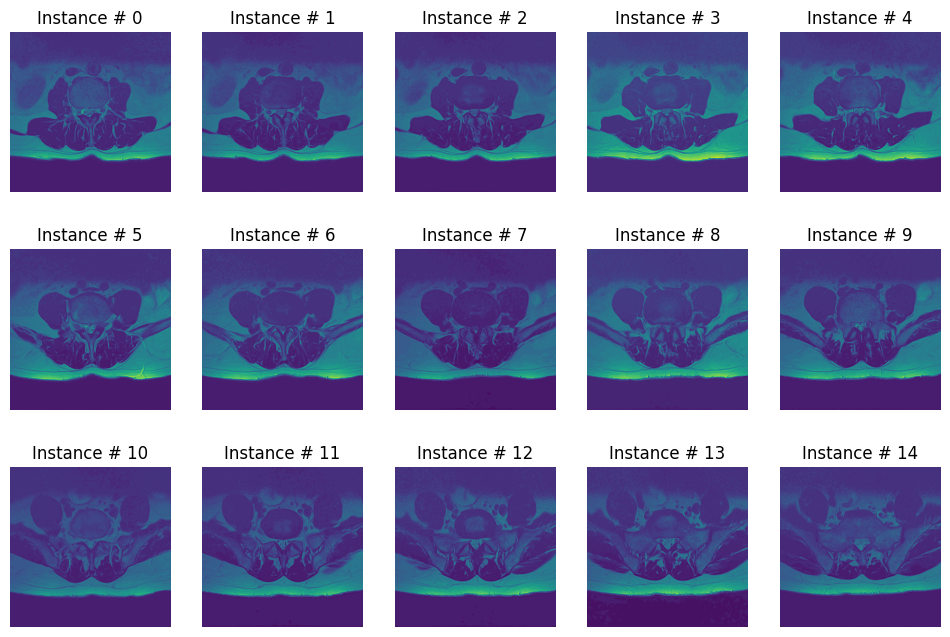

In [119]:
# Visualize a series of MRI images 
def visualize_series(study_id,series_id):
    ncols = 5
    nrows = math.ceil(len(os.listdir(train_images_path + "/" + str(study_id) + "/" + str(series_id))) / ncols)
    # Create subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 8))
    dicom_dir = train_images_path + "/" + str(study_id) + "/" + str(series_id)
    dicom_files = [pydicom.dcmread(os.path.join(dicom_dir, f)) for f in sorted(os.listdir(dicom_dir)) if f.endswith('.dcm')]
    dicom_files.sort(key=lambda x: x.InstanceNumber)
    # Flatten the axes array for easy iteration
    axes = axes.flatten()
    for i,dicom_data in enumerate(dicom_files):
        pixel_spacing = list(dicom_data.PixelSpacing) + [dicom_data.SliceThickness]
        image = sitk.GetImageFromArray(dicom_data.pixel_array)
        image.SetSpacing(pixel_spacing)
        wo_bias_image = z_score_normalization(image)
        wo_bias_image = discretize_image(wo_bias_image)
        wo_bias_image = convert_to_png(wo_bias_image)
        image_array = np.array(wo_bias_image)
        resized_image_array = cv2.resize(image_array, (512,512), interpolation=cv2.INTER_CUBIC)
        axes[i].imshow(resized_image_array)
        axes[i].set_title(f'Instance # {i}')
        axes[i].axis('off')
    for i in range(len(dicom_files),len(axes)):
        axes[i].axis('off')

    plt.show()
visualize_series(2883475064,1297772737)

## Instance Slice Location Check

In [100]:
# Directory containing the DICOM filesd
def check_instance_slice_location(study_id,series_id):
    dicom_dir = f'/home/tiny_ling/projects/kaggle/rsna-2024-lumbar-degenerative-classication/rsna-2024-lumbar-spine-degenerative-classification/train_images/{study_id}/{series_id}'

    # Read the DICOM files
    dicom_files = [pydicom.dcmread(os.path.join(dicom_dir, f)) for f in sorted(os.listdir(dicom_dir)) if f.endswith('.dcm')]

    # Sort the DICOM files by InstanceNumber
    dicom_files.sort(key=lambda x: x.InstanceNumber)
    instance_number_list = np.asarray([file.InstanceNumber for file in dicom_files])
    slice_location_list = np.asarray([file.SliceLocation for file in dicom_files])

    is_monotonic_increasing = True if np.all(np.diff(slice_location_list)>0) else False
    is_monotonic_decreasing = True if np.all(np.diff(slice_location_list)<0) else False

    if not is_monotonic_increasing and not is_monotonic_decreasing:
        # print("-----------------------------------------------")
        # print(f"Study ID: {study_id} - Series ID: {series_id}")
        # print("Slice location list does not strictyly increase or decrease monotonically")
        # print(f"Instance Number list : {instance_number_list}")
        # print(f"Slice location list: {slice_location_list}")
        return True
    else:
        return False

slice_location_faulty_ids  = []
for i in os.listdir(train_images_path):
    for j in os.listdir(os.path.join(train_images_path,i)):
        if check_instance_slice_location(i,j):
            slice_location_faulty_ids.append((i,j,len(os.listdir(os.path.join(train_images_path,i)+"/"+str(j)))))

print(len(slice_location_faulty_ids))

537


In [ ]:
slice_location_faulty_ids

## Defining our dataframe 

In [121]:
train_csv_path = "/home/tiny_ling/projects/kaggle/rsna-2024-lumbar-degenerative-classication/rsna-2024-lumbar-spine-degenerative-classification/train.csv"
train_label_coordinates_path = "/home/tiny_ling/projects/kaggle/rsna-2024-lumbar-degenerative-classication/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv"
train_series_desc_path = "/home/tiny_ling/projects/kaggle/rsna-2024-lumbar-degenerative-classication/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv"
train_images_path = "/home/tiny_ling/projects/kaggle/rsna-2024-lumbar-degenerative-classication/rsna-2024-lumbar-spine-degenerative-classification/train_images"

df_train = pd.read_csv(train_csv_path)
df_train_desc = pd.read_csv(train_label_coordinates_path)
df_train_series_desc = pd.read_csv(train_series_desc_path)
df_train_desc['image_path'] = train_images_path + "/" + df_train_desc['study_id'].astype(str) +"/"+ df_train_desc['series_id'].astype(str) + "/"+ df_train_desc['instance_number'].astype(str) + ".dcm"

In [122]:
# This line basically turns the 25 conditions as origianlly had as columns, turn them into an extra column, so we have col: study_id,condition_level,value
df_train_melted = df_train.melt(id_vars=['study_id'], var_name='condition_level', value_name='value')
df_train_melted[['conditions', 'level']] = df_train_melted['condition_level'].str.rsplit('_', n=2, expand=True).iloc[:, 1:]
df_train_melted['condition'] = df_train_melted['condition_level'].apply(lambda x: '_'.join(x.split('_')[:-2])).str.replace("_"," ").str.title()
df_train_melted['level'] = df_train_melted['conditions'].str.upper() +"/"+ df_train_melted['level'].str.upper()
df_train_melted = df_train_melted.drop(columns=['condition_level', 'conditions'])
df_train_melted = df_train_melted.rename(columns={'value': 'severity'})
df_final = df_train_desc.merge(df_train_melted, on=["study_id","level","condition"],how="left")
df_final = df_final.merge(df_train_series_desc,on=["study_id","series_id"],how="left")
df_final = df_final.rename(columns={'series_description': 'orientation'})


In [123]:
df_final

,study_id,series_id,instance_number,condition,level,x,y,image_path,severity,orientation
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,/home/tiny_ling/projects/kaggle/rsna-2024-lumb...,Normal/Mild,Sagittal T2/STIR
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286,/home/tiny_ling/projects/kaggle/rsna-2024-lumb...,Normal/Mild,Sagittal T2/STIR
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182,/home/tiny_ling/projects/kaggle/rsna-2024-lumb...,Normal/Mild,Sagittal T2/STIR
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434,/home/tiny_ling/projects/kaggle/rsna-2024-lumb...,Normal/Mild,Sagittal T2/STIR
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602,/home/tiny_ling/projects/kaggle/rsna-2024-lumb...,Normal/Mild,Sagittal T2/STIR
...,...,...,...,...,...,...,...,...,...,...
48687,4290709089,4237840455,11,Left Neural Foraminal Narrowing,L1/L2,219.465940,97.831063,/home/tiny_ling/projects/kaggle/rsna-2024-lumb...,Normal/Mild,Sagittal T1
48688,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L2/L3,205.340599,140.207084,/home/tiny_ling/projects/kaggle/rsna-2024-lumb...,Normal/Mild,Sagittal T1
48689,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L3/L4,202.724796,181.013624,/home/tiny_ling/projects/kaggle/rsna-2024-lumb...,Normal/Mild,Sagittal T1
48690,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L4/L5,202.933333,219.733333,/home/tiny_ling/projects/kaggle/rsna-2024-lumb...,Normal/Mild,Sagittal T1


In [124]:
# Categorical Encoding of Features
IS_RANDOM = False
# encode severity
def encode_severity(severity):
    is_random = IS_RANDOM
    if severity == "Normal/Mild":
        return random.random()*0.3333 if is_random else 0.3333
    elif severity == "Moderate":
        return random.random()*0.3333 + 0.3333 if is_random else 0.6666
    else:
        return random.random()*0.3333 + 0.6666 if is_random else 0.9999 

#encode orientation
def encode_orientation(orientation):
    if  orientation == "Axial T2":
        return 0
    elif orientation == "Sagittal T1":
        return 1
    elif orientation == "Sagittal T2/STIR":
        return 2

df_final['severity'] = df_final['severity'].apply(encode_severity)
df_final['orientation'] = df_final['orientation'].apply(encode_orientation)


## Defining our Dataset Class

In [128]:
# Defining our dataset class 
class RSNADataset(Dataset):
    def __init__(self,df,cross_fold):
        self.df = df
        self.cross_fold = cross_fold
        self.transforms = transforms.Compose([
            ToTensor(),
            Lambda(lambda x: x/255.0 - 0.5),
        ])

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        image_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['severity']
        orientation = self.df.iloc[idx]['orientation']
        image = preprocess_mri_image(image_path,"wo_bc")
        image = self.transforms(image)
        return image, orientation, label


dataset = RSNADataset(df=df_final,cross_fold=False)
batch_size = 16
if dataset.cross_fold:
    pass
else:
    dataset_len = len(dataset)
    train_split= int(dataset_len* 0.7)
    val_split = int(dataset_len*0.2)
    indices = range(0,dataset_len)
    # Define list of indices
    train_indices = indices[:train_split]
    val_indices = indices[train_split:val_split]
    test_indices = indices[val_split:]
    # Define samplers
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(train_indices)
    #Define dataloaders
    train_loader = DataLoader(dataset=dataset, batch_size = batch_size, sampler=train_sampler, drop_last=True)
    val_loader =   DataLoader(dataset=dataset, batch_size = batch_size, sampler=val_sampler, drop_last=True)
    test_loader =  DataLoader(dataset=dataset, batch_size = batch_size, sampler=test_sampler, drop_last=True)
    
    



## Model Development

In [48]:
from transformers import AutoImageProcessor, Dinov2Model
import torch
from datasets import load_dataset

dataset = load_dataset("huggingface/cats-image", trust_remote_code=True)
image = dataset["test"]["image"][0]

image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
model = Dinov2Model.from_pretrained("facebook/dinov2-base")

inputs = image_processor(image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
list(last_hidden_states.shape)

ModuleNotFoundError: No module named 'transformers'